In [ ]:
import torch
import torch.nn as nn
from dataloaders import load_cifar10
from trainer import Trainer, compute_loss_and_accuracy
from task2 import create_plots

In [ ]:
class Model1(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:

                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """



        super().__init__()
        # TODO: Implement this function (Task  2a)

        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential( # The output of feature_extractor_1 will be [batch_size, num_filters, 16, 16]            #Layer1
            #Layer 1
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            #Layer 2
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            #Layer 3
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
        )
        
        #Fully connected below
        self.fc = self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 64), #after 3 maxpools where each halves "x-y" dimensions
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
        )

        self.num_output_features = 32*32*32
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
       

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = x
        expected_shape = (batch_size, self.num_classes)
        out = self.feature_extractor(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)  
        
        
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [ ]:
epochs = 10
batch_size = 64
learning_rate = 5e-2 # Should be 5e-5 for LeNet
early_stop_count = 7
dataloaders = load_cifar10(batch_size)
model = Model1(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloaders,
)
trainer.train()

Files already downloaded and verified
Files already downloaded and verified



  0%|          | 0/10 [00:00<?, ?it/s]

Model1(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): BatchNorm2d(128, eps=1e-05, mo


 10%|█         | 1/10 [00:21<03:11, 21.28s/it]

Epoch: 0, Batches per seconds: 33.09, Global step:    702, Validation Loss: 1.03, Validation Accuracy: 0.623
Epoch: 1, Batches per seconds: 32.84, Global step:   1053, Validation Loss: 1.01, Validation Accuracy: 0.641



 20%|██        | 2/10 [00:42<02:50, 21.31s/it]

Epoch: 1, Batches per seconds: 32.98, Global step:   1404, Validation Loss: 0.86, Validation Accuracy: 0.691
Epoch: 2, Batches per seconds: 32.86, Global step:   1755, Validation Loss: 0.80, Validation Accuracy: 0.712



 30%|███       | 3/10 [01:03<02:29, 21.31s/it]

Epoch: 2, Batches per seconds: 32.96, Global step:   2106, Validation Loss: 0.85, Validation Accuracy: 0.706
Epoch: 3, Batches per seconds: 32.94, Global step:   2457, Validation Loss: 0.78, Validation Accuracy: 0.725



 40%|████      | 4/10 [01:25<02:07, 21.24s/it]

Epoch: 3, Batches per seconds: 33.06, Global step:   2808, Validation Loss: 0.71, Validation Accuracy: 0.747
Epoch: 4, Batches per seconds: 33.02, Global step:   3159, Validation Loss: 0.67, Validation Accuracy: 0.764



 50%|█████     | 5/10 [01:46<01:46, 21.22s/it]

Epoch: 4, Batches per seconds: 33.09, Global step:   3510, Validation Loss: 0.69, Validation Accuracy: 0.754
Epoch: 5, Batches per seconds: 33.03, Global step:   3861, Validation Loss: 0.72, Validation Accuracy: 0.748
Epoch: 5, Batches per seconds: 33.11, Global step:   4212, Validation Loss: 0.65, Validation Accuracy: 0.767



 60%|██████    | 6/10 [02:07<01:24, 21.21s/it]

Epoch: 6, Batches per seconds: 33.09, Global step:   4563, Validation Loss: 0.72, Validation Accuracy: 0.745
Epoch: 6, Batches per seconds: 33.17, Global step:   4914, Validation Loss: 0.61, Validation Accuracy: 0.787



 70%|███████   | 7/10 [02:28<01:03, 21.13s/it]

Epoch: 7, Batches per seconds: 33.14, Global step:   5265, Validation Loss: 0.64, Validation Accuracy: 0.771
Epoch: 7, Batches per seconds: 33.18, Global step:   5616, Validation Loss: 0.61, Validation Accuracy: 0.782



 80%|████████  | 8/10 [02:49<00:42, 21.14s/it]

Epoch: 8, Batches per seconds: 33.15, Global step:   5967, Validation Loss: 0.59, Validation Accuracy: 0.794
Epoch: 8, Batches per seconds: 33.20, Global step:   6318, Validation Loss: 0.59, Validation Accuracy: 0.796



 90%|█████████ | 9/10 [03:10<00:21, 21.10s/it]

Epoch: 9, Batches per seconds: 33.19, Global step:   6669, Validation Loss: 0.58, Validation Accuracy: 0.798
Epoch: 9, Batches per seconds: 33.23, Global step:   7020, Validation Loss: 0.58, Validation Accuracy: 0.797



100%|██████████| 10/10 [03:31<00:00, 21.16s/it]


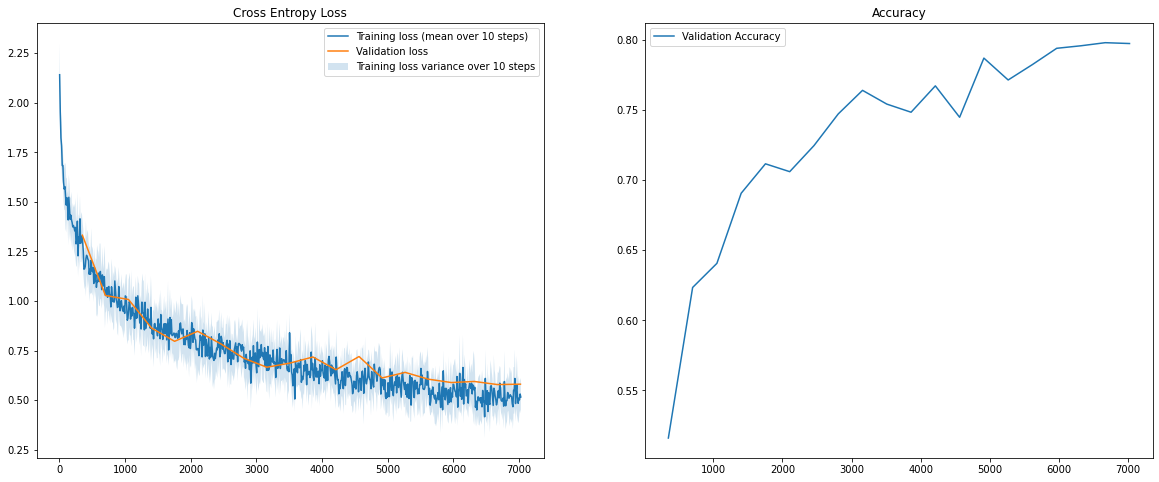

In [ ]:
create_plots(trainer, "task3")

In [ ]:
trainer.load_best_model()
test_set = trainer.dataloader_test
val_set = trainer.dataloader_val
train_set = trainer.dataloader_train

#create_plots(trainer, "task2_1")
print(compute_loss_and_accuracy(dataloader=test_set,model = model, loss_criterion=nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(dataloader=val_set,model = model, loss_criterion=nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(dataloader=train_set,model = model, loss_criterion=nn.CrossEntropyLoss()))

(tensor(0.6862, device='cuda:0'), 0.7639)
(tensor(0.6921, device='cuda:0'), 0.7592)
(tensor(0.4860, device='cuda:0'), 0.8291696301564723)


In [ ]:
class Model2(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:

                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """



        super().__init__()
        # TODO: Implement this function (Task  2a)

        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential( # The output of feature_extractor_1 will be [batch_size, num_filters, 16, 16]            #Layer1
            #Layer 1
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.SiLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            #Layer 2
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            #Layer 3
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.SiLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
        )
        
        #Fully connected below
        self.fc = self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 64), #after 3 maxpools where each halves "x-y" dimensions
            nn.SiLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
        )

        self.num_output_features = 32*32*32
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
       

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = x
        expected_shape = (batch_size, self.num_classes)
        out = self.feature_extractor(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)  
        
        
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [ ]:
epochs = 10
batch_size = 64
learning_rate = 5e-2 # Should be 5e-5 for LeNet
early_stop_count = 7
dataloaders = load_cifar10(batch_size)
model_2 = Model2(image_channels=3, num_classes=10)
trainer_2 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model_2,
    dataloaders,
)
trainer_2.train()

Files already downloaded and verified
Files already downloaded and verified



  0%|          | 0/10 [00:00<?, ?it/s]

Model2(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): SiLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): SiLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): SiLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): BatchNorm2d(128, eps=1e-05, mo


 10%|█         | 1/10 [00:21<03:11, 21.28s/it]

Epoch: 0, Batches per seconds: 33.09, Global step:    702, Validation Loss: 1.05, Validation Accuracy: 0.633
Epoch: 1, Batches per seconds: 32.89, Global step:   1053, Validation Loss: 0.91, Validation Accuracy: 0.686



 20%|██        | 2/10 [00:42<02:49, 21.22s/it]

Epoch: 1, Batches per seconds: 33.22, Global step:   1404, Validation Loss: 0.82, Validation Accuracy: 0.714
Epoch: 2, Batches per seconds: 33.26, Global step:   1755, Validation Loss: 0.78, Validation Accuracy: 0.736



 30%|███       | 3/10 [01:03<02:27, 21.09s/it]

Epoch: 2, Batches per seconds: 33.40, Global step:   2106, Validation Loss: 0.72, Validation Accuracy: 0.751
Epoch: 3, Batches per seconds: 33.38, Global step:   2457, Validation Loss: 0.71, Validation Accuracy: 0.756



 40%|████      | 4/10 [01:23<02:06, 21.01s/it]

Epoch: 3, Batches per seconds: 33.50, Global step:   2808, Validation Loss: 0.68, Validation Accuracy: 0.764
Epoch: 4, Batches per seconds: 33.44, Global step:   3159, Validation Loss: 0.68, Validation Accuracy: 0.766



 50%|█████     | 5/10 [01:44<01:44, 20.95s/it]

Epoch: 4, Batches per seconds: 33.55, Global step:   3510, Validation Loss: 0.67, Validation Accuracy: 0.771
Epoch: 5, Batches per seconds: 33.54, Global step:   3861, Validation Loss: 0.63, Validation Accuracy: 0.784



 60%|██████    | 6/10 [02:05<01:23, 20.91s/it]

Epoch: 5, Batches per seconds: 33.59, Global step:   4212, Validation Loss: 0.62, Validation Accuracy: 0.789
Epoch: 6, Batches per seconds: 33.56, Global step:   4563, Validation Loss: 0.62, Validation Accuracy: 0.787
Epoch: 6, Batches per seconds: 33.58, Global step:   4914, Validation Loss: 0.60, Validation Accuracy: 0.798



 70%|███████   | 7/10 [02:26<01:02, 20.92s/it]

Epoch: 7, Batches per seconds: 33.58, Global step:   5265, Validation Loss: 0.61, Validation Accuracy: 0.793
Epoch: 7, Batches per seconds: 33.63, Global step:   5616, Validation Loss: 0.58, Validation Accuracy: 0.802



 80%|████████  | 8/10 [02:47<00:41, 20.85s/it]

Epoch: 8, Batches per seconds: 33.65, Global step:   5967, Validation Loss: 0.61, Validation Accuracy: 0.797
Epoch: 8, Batches per seconds: 33.71, Global step:   6318, Validation Loss: 0.58, Validation Accuracy: 0.801



 90%|█████████ | 9/10 [03:07<00:20, 20.73s/it]

Epoch: 9, Batches per seconds: 33.66, Global step:   6669, Validation Loss: 0.61, Validation Accuracy: 0.800
Epoch: 9, Batches per seconds: 33.70, Global step:   7020, Validation Loss: 0.56, Validation Accuracy: 0.811



100%|██████████| 10/10 [03:28<00:00, 20.86s/it]


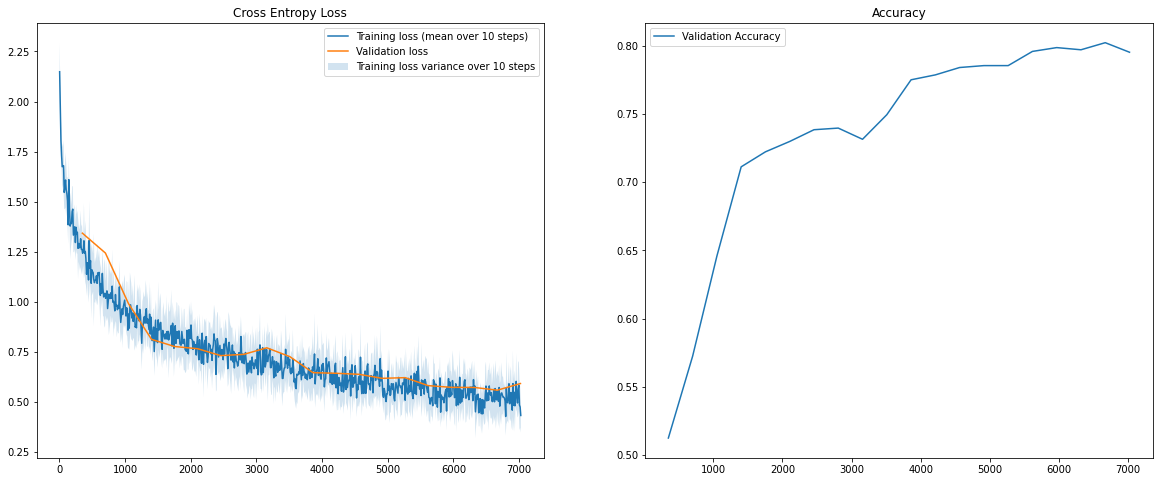

In [ ]:
create_plots(trainer, "task3a_2")

In [ ]:
trainer_2.load_best_model()
test_set = trainer.dataloader_test
val_set = trainer.dataloader_val
train_set = trainer.dataloader_train

#create_plots(trainer, "task2_1")
print(compute_loss_and_accuracy(dataloader=test_set,model = model, loss_criterion=nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(dataloader=val_set,model = model, loss_criterion=nn.CrossEntropyLoss()))
print(compute_loss_and_accuracy(dataloader=train_set,model = model, loss_criterion=nn.CrossEntropyLoss()))

(tensor(0.6983, device='cuda:0'), 0.7586)
(tensor(0.6906, device='cuda:0'), 0.7654)
(tensor(0.4722, device='cuda:0'), 0.8326146870554765)


## Task 3 - multiple plots describing the best change



In [ ]:
class Model3c_1(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:

                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """



        super().__init__()
        # TODO: Implement this function (Task  2a)

        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential( # The output of feature_extractor_1 will be [batch_size, num_filters, 16, 16]            #Layer1
            #Layer 1
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            #Layer 2
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            #Layer 3
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
        )
        
        #Fully connected below
        self.fc = self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 64), #after 3 maxpools where each halves "x-y" dimensions
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
        )

        self.num_output_features = 32*32*32
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
       

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = x
        expected_shape = (batch_size, self.num_classes)
        out = self.feature_extractor(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)  
        
        
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [ ]:
class Model3c_2(nn.Module):

    def __init__(self,
                 image_channels,
                 num_classes):
        """
            Is called when model is initialized.
            Args:

                image_channels. Number of color channels in image (3)
                num_classes: Number of classes we want to predict (10)
        """



        super().__init__()
        # TODO: Implement this function (Task  2a)

        self.num_classes = num_classes
        # Define the convolutional layers
        self.feature_extractor = nn.Sequential( # The output of feature_extractor_1 will be [batch_size, num_filters, 16, 16]            #Layer1
            #Layer 1
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(32),
            #Layer 2
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(64),
            #Layer 3
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #nn.Dropout(0.2),
            nn.BatchNorm2d(128),
        )
        
        #Fully connected below
        self.fc = self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 64), #after 3 maxpools where each halves "x-y" dimensions
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 10),
        )

        self.num_output_features = 32*32*32
        # Initialize our last fully connected layer
        # Inputs all extracted features from the convolutional layers
        # Outputs num_classes predictions, 1 for each class.
        # There is no need for softmax activation function, as this is
        # included with nn.CrossEntropyLoss
       

    def forward(self, x):
        """
        Performs a forward pass through the model
        Args:
            x: Input image, shape: [batch_size, 3, 32, 32]
        """
        # TODO: Implement this function (Task  2a)
        batch_size = x.shape[0]
        out = x
        expected_shape = (batch_size, self.num_classes)
        out = self.feature_extractor(out)
        out = out.view(batch_size, -1)
        out = self.fc(out)  
        
        
        assert out.shape == (batch_size, self.num_classes),\
            f"Expected output of forward pass to be: {expected_shape}, but got: {out.shape}"
        return out


In [ ]:
epochs = 10
batch_size = 64
learning_rate = 5e-2 # Should be 5e-5 for LeNet
early_stop_count = 7
dataloaders = load_cifar10(batch_size)
model_3c1 = Model3c_1(image_channels=3, num_classes=10)
trainer_3c1 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model_3c1,
    dataloaders,
)
trainer_3c1.train()

Files already downloaded and verified
Files already downloaded and verified





  0%|          | 0/10 [00:00<?, ?it/s]

Model3c_1(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.2, inplace=False)
    (16): BatchNorm2d(128, eps=1e-05,




 10%|█         | 1/10 [00:21<03:10, 21.16s/it]

Epoch: 0, Batches per seconds: 33.27, Global step:    702, Validation Loss: 1.09, Validation Accuracy: 0.612
Epoch: 1, Batches per seconds: 33.26, Global step:   1053, Validation Loss: 0.91, Validation Accuracy: 0.671





 20%|██        | 2/10 [00:41<02:48, 21.04s/it]

Epoch: 1, Batches per seconds: 33.56, Global step:   1404, Validation Loss: 0.91, Validation Accuracy: 0.675
Epoch: 2, Batches per seconds: 33.59, Global step:   1755, Validation Loss: 0.80, Validation Accuracy: 0.710





 30%|███       | 3/10 [01:02<02:26, 20.93s/it]

Epoch: 2, Batches per seconds: 33.71, Global step:   2106, Validation Loss: 0.75, Validation Accuracy: 0.736
Epoch: 3, Batches per seconds: 33.56, Global step:   2457, Validation Loss: 0.71, Validation Accuracy: 0.750





 40%|████      | 4/10 [01:23<02:05, 20.96s/it]

Epoch: 3, Batches per seconds: 33.64, Global step:   2808, Validation Loss: 0.68, Validation Accuracy: 0.757
Epoch: 4, Batches per seconds: 33.62, Global step:   3159, Validation Loss: 0.73, Validation Accuracy: 0.742





 50%|█████     | 5/10 [01:44<01:44, 20.95s/it]

Epoch: 4, Batches per seconds: 33.62, Global step:   3510, Validation Loss: 0.65, Validation Accuracy: 0.765
Epoch: 5, Batches per seconds: 33.59, Global step:   3861, Validation Loss: 0.63, Validation Accuracy: 0.780





 60%|██████    | 6/10 [02:05<01:23, 20.89s/it]

Epoch: 5, Batches per seconds: 33.67, Global step:   4212, Validation Loss: 0.72, Validation Accuracy: 0.743
Epoch: 6, Batches per seconds: 33.62, Global step:   4563, Validation Loss: 0.61, Validation Accuracy: 0.785
Epoch: 6, Batches per seconds: 33.67, Global step:   4914, Validation Loss: 0.62, Validation Accuracy: 0.784





 70%|███████   | 7/10 [02:26<01:02, 20.88s/it]

Epoch: 7, Batches per seconds: 33.63, Global step:   5265, Validation Loss: 0.61, Validation Accuracy: 0.786
Epoch: 7, Batches per seconds: 33.68, Global step:   5616, Validation Loss: 0.57, Validation Accuracy: 0.794





 80%|████████  | 8/10 [02:46<00:41, 20.87s/it]

Epoch: 8, Batches per seconds: 33.64, Global step:   5967, Validation Loss: 0.56, Validation Accuracy: 0.808
Epoch: 8, Batches per seconds: 33.67, Global step:   6318, Validation Loss: 0.58, Validation Accuracy: 0.797





 90%|█████████ | 9/10 [03:07<00:20, 20.88s/it]

Epoch: 9, Batches per seconds: 33.65, Global step:   6669, Validation Loss: 0.56, Validation Accuracy: 0.809
Epoch: 9, Batches per seconds: 33.70, Global step:   7020, Validation Loss: 0.54, Validation Accuracy: 0.808





100%|██████████| 10/10 [03:28<00:00, 20.86s/it]


In [ ]:
epochs = 10
batch_size = 64
learning_rate = 5e-2 # Should be 5e-5 for LeNet
early_stop_count = 7
dataloaders = load_cifar10(batch_size)
model_3c2 = Model3c_2(image_channels=3, num_classes=10)
trainer_3c2 = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model_3c2,
    dataloaders,
)
trainer_3c2.train()

Files already downloaded and verified
Files already downloaded and verified





  0%|          | 0/10 [00:00<?, ?it/s]

Model3c_2(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_feat




 10%|█         | 1/10 [00:20<03:05, 20.65s/it]

Epoch: 0, Batches per seconds: 34.10, Global step:    702, Validation Loss: 0.95, Validation Accuracy: 0.671
Epoch: 1, Batches per seconds: 33.95, Global step:   1053, Validation Loss: 0.84, Validation Accuracy: 0.703





 20%|██        | 2/10 [00:41<02:45, 20.64s/it]

Epoch: 1, Batches per seconds: 34.10, Global step:   1404, Validation Loss: 0.73, Validation Accuracy: 0.750
Epoch: 2, Batches per seconds: 34.03, Global step:   1755, Validation Loss: 0.70, Validation Accuracy: 0.754





 30%|███       | 3/10 [01:01<02:24, 20.65s/it]

Epoch: 2, Batches per seconds: 34.06, Global step:   2106, Validation Loss: 0.68, Validation Accuracy: 0.770
Epoch: 3, Batches per seconds: 34.04, Global step:   2457, Validation Loss: 0.69, Validation Accuracy: 0.768





 40%|████      | 4/10 [01:22<02:03, 20.55s/it]

Epoch: 3, Batches per seconds: 34.20, Global step:   2808, Validation Loss: 0.66, Validation Accuracy: 0.770
Epoch: 4, Batches per seconds: 34.16, Global step:   3159, Validation Loss: 0.71, Validation Accuracy: 0.763





 50%|█████     | 5/10 [01:42<01:42, 20.52s/it]

Epoch: 4, Batches per seconds: 34.24, Global step:   3510, Validation Loss: 0.69, Validation Accuracy: 0.774
Epoch: 5, Batches per seconds: 34.17, Global step:   3861, Validation Loss: 0.70, Validation Accuracy: 0.770





 60%|██████    | 6/10 [02:03<01:22, 20.53s/it]

Epoch: 5, Batches per seconds: 34.23, Global step:   4212, Validation Loss: 0.70, Validation Accuracy: 0.780
Epoch: 6, Batches per seconds: 34.20, Global step:   4563, Validation Loss: 0.76, Validation Accuracy: 0.767
Epoch: 6, Batches per seconds: 34.24, Global step:   4914, Validation Loss: 0.78, Validation Accuracy: 0.765
Early stop criteria met
Early stopping.


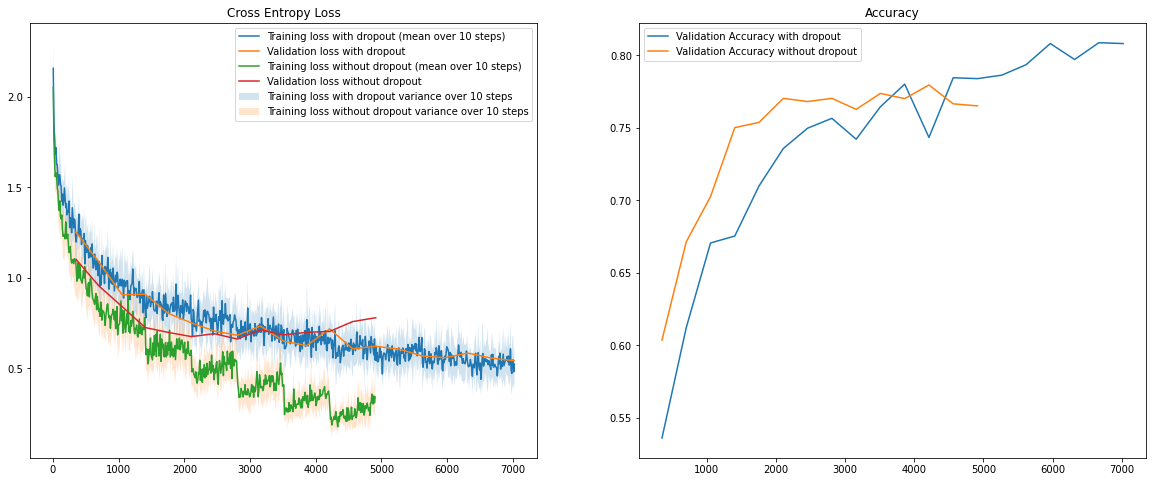

In [ ]:
import pathlib
import matplotlib.pyplot as plt
import utils


plot_path = pathlib.Path("plots")
plot_path.mkdir(exist_ok=True)
# Save plots and show them
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Cross Entropy Loss")
utils.plot_loss(trainer_3c1.train_history["loss"], label="Training loss with dropout", npoints_to_average=10)
utils.plot_loss(trainer_3c1.validation_history["loss"], label="Validation loss with dropout")
utils.plot_loss(trainer_3c2.train_history["loss"], label="Training loss without dropout", npoints_to_average=10)
utils.plot_loss(trainer_3c2.validation_history["loss"], label="Validation loss without dropout")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy")
utils.plot_loss(trainer_3c1.validation_history["accuracy"], label="Validation Accuracy with dropout")
utils.plot_loss(trainer_3c2.validation_history["accuracy"], label="Validation Accuracy without dropout")

plt.legend()
plt.savefig(plot_path.joinpath("task3c.png"))
plt.show()